In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout

import cv2
import pandas as pd
import dlib

In [2]:
for i in range(1000):
    globals()['land'+str(i)] = pd.read_csv('./dlib1000/train/%s.csv'%i)
    globals()['land'+str(i)] = np.array(globals()['land'+str(i)])
    
    tr_x = globals()['land'+str(i)][:, 0]
    tr_y = globals()['land'+str(i)][:, 1]
    
    tr_cx = ((min(tr_x)+max(tr_x)) / 2)        #dlib_rect 중점
    tr_cy = ((min(tr_y)+max(tr_y)) / 2)
    
    tr_h = max(tr_y)-min(tr_y)    #종축 길이
    
    tr_x -= tr_cx
    tr_y -= tr_cy
    
    norm_trx = (tr_x - min(tr_x)) / (tr_h * 1.5)
    norm_try = (tr_y - min(tr_y)) / (tr_h *1.5)
    
    globals()['train_norm'+str(i)] = np.column_stack((norm_trx, norm_try))

In [3]:
## eye, nose, mouth, jaws
for i in  range(1000):
    globals()['norm_eye'+str(i)] = globals()['train_norm'+str(i)][36:48].flatten()
    globals()['norm_nose'+str(i)] = globals()['train_norm'+str(i)][27:36].flatten()
    globals()['norm_mouth'+str(i)] = globals()['train_norm'+str(i)][48:].flatten()
    globals()['norm_jaws'+str(i)] = globals()['train_norm'+str(i)][:17].flatten()

In [4]:
train_x = np.zeros((1000, len(norm_eye0)))   #eye
for i in range(1000):
    for j in range(len(norm_eye0)):
        train_x[i][j] = globals()['norm_eye'+str(i)][j]   

In [5]:
try_eye = pd.read_csv('./DataSet1000/train/csv/train.csv')
try_eye = try_eye.iloc[:, 19]

In [6]:
for i in range(1000):
    globals()['mark'+str(i)] = pd.read_csv('./dlib1000/test/%s.csv'%i)
    globals()['mark'+str(i)] = np.array(globals()['mark'+str(i)])
    
    te_x = globals()['mark'+str(i)][:, 0]
    te_y = globals()['mark'+str(i)][:, 1]
    
    te_cx = ((min(te_x)+max(te_x)) / 2)
    te_cy = ((min(te_y)+max(te_y)) / 2)

    te_h = max(te_y)-min(te_y)
    
    
    te_x -= te_cx
    te_y -= te_cy

    norm_tex = (te_x - min(te_x)) / (te_h *1.5)
    norm_tey = (te_y - min(te_y)) / (te_h *1.5)
    
    globals()['test_norm'+str(i)] = np.column_stack((norm_tex, norm_tey))

In [7]:
## eye, nose, mouth, jaws
for i in  range(1000):
    globals()['norm_eye2'+str(i)] = globals()['test_norm'+str(i)][36:48].flatten()
    globals()['norm_nose2'+str(i)] = globals()['test_norm'+str(i)][27:36].flatten()
    globals()['norm_mouth2'+str(i)] = globals()['test_norm'+str(i)][48:].flatten()
    globals()['norm_jaws2'+str(i)] = globals()['test_norm'+str(i)][:17].flatten()

In [8]:
test_x = np.zeros((1000, len(norm_eye20)))
for i in range(1000):
    for j in range(len(norm_eye20)):
        test_x[i][j] = globals()['norm_eye2'+str(i)][j]  

In [9]:
tey_eye = pd.read_csv('./DataSet1000/test/csv/test.csv')
tey_eye = tey_eye.iloc[:, 19]

In [12]:
def build_model():
    model = keras.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_x.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics='mae')
    
    return model

In [22]:
k = 4

num_val_samples = len(train_x) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_x[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = try_eye[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(  
        [train_x[:i * num_val_samples],
         train_x[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [try_eye[:i * num_val_samples],
         try_eye[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    model.fit(partial_train_data, partial_train_targets,  
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0) 
    all_scores.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [25]:
np.mean(all_scores)

0.17522919178009033

In [28]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_x[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(  
        [train_x[:i * num_val_samples],
         train_x[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [try_eye[:i * num_val_samples],
         try_eye[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()  
    history = model.fit(partial_train_data, partial_train_targets,
                    validation_data=(val_data, val_targets),
                    epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [29]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [35]:
average_mae_history

[0.24250528216362,
 0.24399924278259277,
 0.242454182356596,
 0.2519642561674118,
 0.24267667531967163,
 0.24365074932575226,
 0.24087023362517357,
 0.2413751743733883,
 0.24533968791365623,
 0.24474594369530678,
 0.25477825477719307,
 0.2443746216595173,
 0.2443840429186821,
 0.24353747814893723,
 0.24479025974869728,
 0.24668670073151588,
 0.2437155805528164,
 0.2417752966284752,
 0.24196595698595047,
 0.24331624433398247,
 0.24397969990968704,
 0.2431613989174366,
 0.24360834062099457,
 0.250983327627182,
 0.24798858910799026,
 0.24287141487002373,
 0.2465583123266697,
 0.2469749115407467,
 0.24786021932959557,
 0.250012531876564,
 0.24482422322034836,
 0.24803951382637024,
 0.24382201582193375,
 0.25035977363586426,
 0.2478087805211544,
 0.25255047157406807,
 0.2515621893107891,
 0.2576763741672039,
 0.24268986657261848,
 0.25234801694750786,
 0.24767309799790382,
 0.2470107339322567,
 0.2442309930920601,
 0.2436022385954857,
 0.24320710822939873,
 0.2414647825062275,
 0.2492243237

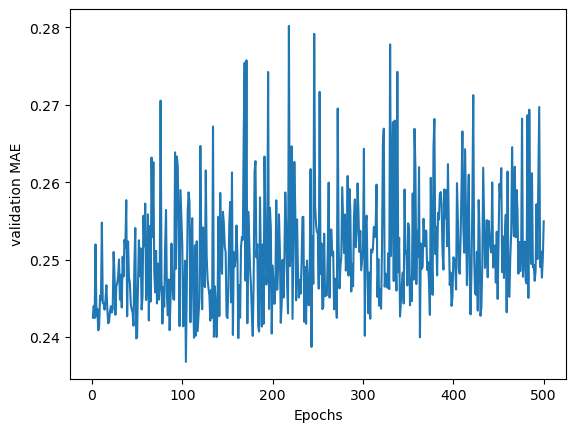

In [33]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('validation MAE')
plt.show()

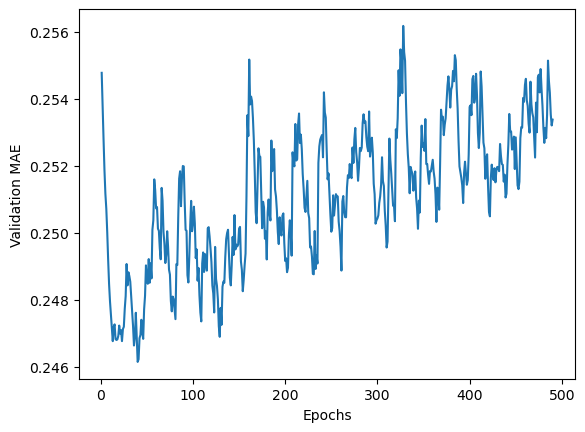

In [38]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [39]:
model = build_model()
model.fit(train_x, try_eye, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_x, tey_eye)

32/32 [==============================] - 0s 581us/step - loss: 0.0636 - mae: 0.2159


In [40]:
test_mae_score

0.21591685712337494

In [41]:
test_mse_score

0.06362830847501755

In [42]:
pred = model.predict(test_x)
df = pd.DataFrame(pred)

df

32/32 [==============================] - 0s 484us/step


,0
0,0.457001
1,0.611836
2,0.626852
3,0.569136
4,0.471427
...,...
995,0.594997
996,0.190940
997,0.450203
998,0.594415


In [43]:
tey_eye

0      0.670021
1      0.858838
2      0.767815
3      0.313305
4      0.746103
         ...   
995    0.998605
996    0.076806
997    0.367089
998    0.791511
999    0.699713
Name: eyeRotation, Length: 1000, dtype: float64

In [44]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(tey_eye, pred)**0.5
print(rmse)

0.25224652649698326


In [45]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(tey_eye, pred)
print(mae)

0.21591684124566646
